In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import RobustScaler

## Training a SARIMA model on the whole data, predicting the level from 2021-12-11 to 2021-12-18

In [11]:
df_original = pd.read_csv('data/Kaub_Level_Since_2013_updated_v2.csv')
path = 'results/' # Used for saving figures later on

In [12]:
df = df_original

In [13]:
print(len(df))

3266


In [14]:
df.tail()

,date,level
3261,2021-12-06,191
3262,2021-12-07,245
3263,2021-12-08,228
3264,2021-12-09,202
3265,2021-12-10,197


In [15]:
df.index = pd.period_range('2013-01-01', '2021-12-10', freq='D')

In [16]:
df = df.drop('date', axis=1)

In [17]:
df

,level
2013-01-01,510
2013-01-02,461
2013-01-03,414
2013-01-04,378
2013-01-05,351
...,...
2021-12-06,191
2021-12-07,245
2021-12-08,228
2021-12-09,202


In [18]:
scaler = RobustScaler().fit(df.values)
df['level'] = scaler.transform(df)

/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


In [19]:
arima_model = auto_arima(df['level'], m=7, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-5593.304, Time=5.77 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-2867.446, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-4913.399, Time=1.53 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-5054.044, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-2869.353, Time=0.12 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=-5599.707, Time=5.30 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=-5601.812, Time=2.41 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=-5602.287, Time=4.62 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=-5603.590, Time=26.28 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=-5592.503, Time=28.81 sec
 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=-5556.088, Time=4.23 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=-5577.890, Time=13.87 sec
 ARIMA(3,1,2)(2,0,0)[7] intercept   : AIC=-5617.323, Time=19.56 sec
 ARIMA(3,1,2)(1,0,0)[7] intercept   : AIC=-5618.715, Time=4.35 sec
 ARIMA(3,1,2)(0

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [21]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  level   No. Observations:                 3266
Model:             SARIMAX(3, 0, 1)x(1, 0, [1, 2], 7)   Log Likelihood                2827.072
Date:                                Tue, 14 Dec 2021   AIC                          -5638.144
Time:                                        11:18:03   BIC                          -5589.413
Sample:                                    01-01-2013   HQIC                         -5620.691
                                         - 12-10-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6818      0.031     53.834      0.000       1.621       1.743
ar.L2         -0.9120      0.057    -16.026      0.000      -1.024      -0.800
ar.L3          0.2072      0.028      7.507      0.000       0.153       0.261
ma.L1          0.3125      0.032      9.746      0.000       0.250       0.375
ar.S.L7        0.6536      0.225      2.902      0.004       0.212       1.095
ma.S.L7       -0.6553      0.223     -2.936      0.003      -1.093      -0.218
ma.S.L14       0.0363      0.020      1.785      0.074      -0.004       0.076
sigma2         0.0103   9.79e-05    105.735      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             22814.93
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             1.29
Prob(H) (two-sided):                  0.28   Kurtosis:                        15.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
order = (3,1,2)
seasonal_order = (0,0,0,7)

In [34]:
model = SARIMAX(df['level'], order=order, seasonal_order=seasonal_order, enforce_stationarity=True)
model_fit = model.fit(maxiter=200, disp=False)

In [36]:
prediction = model_fit.get_forecast(steps=7)

In [37]:
prediction

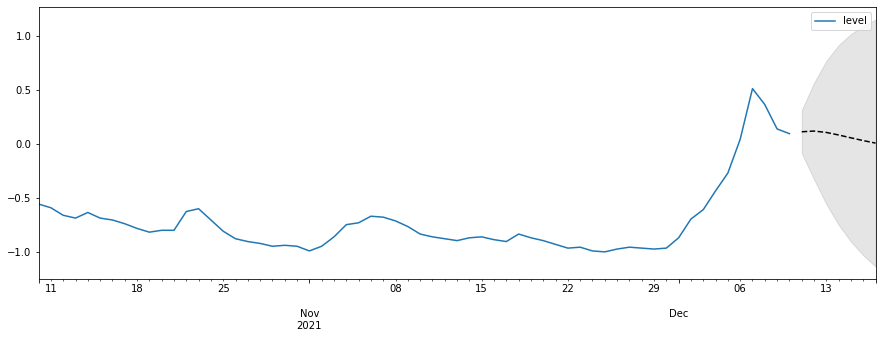

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))

df.loc['2021-10-10':].plot(ax=ax)

fcast = model_fit.get_forecast(steps=7).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.savefig(path + 'sarima_confidence.png')